In [1]:
from obspy.io.segy.core import _read_segy


import obspy

import numpy as np
import matplotlib.pylab as plt
from matplotlib_scalebar.scalebar import ScaleBar

%matplotlib inline

from obspy.signal import rotate


import notch_bp


import particle_motion

from flinn_khalil import flinn as fln
from plot_waveforms import plot_vib_data, plot_geophone

import pandas as pd



C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':


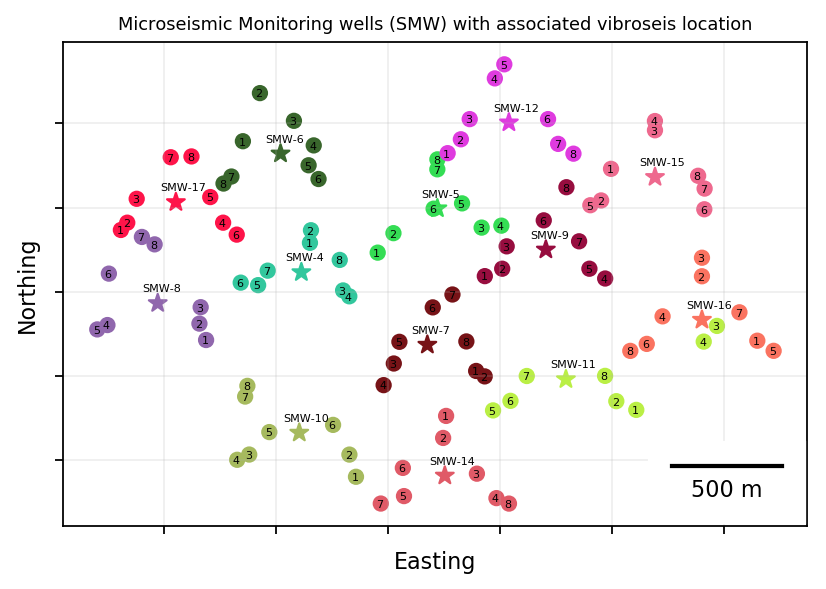

In [2]:
import random


df = pd.read_excel('allwells.xlsx' ,header=None, names = ['vib','x','y'])

df_well = df[df.vib.str.contains("SMW") == True]
df_vib = df[df.vib.str.contains("SMW") == False]
dframes = [df_vib, df_well]
color = np.sort([''.join([random.choice('0123456789ABCDEF') for x in range(6)]) for i in range(13)]*8)
color = ['#' + s for s in color]

df_vib['color'] = color

fig, ax = plt.subplots(dpi=160)

ax.scatter(df_vib.x, df_vib.y, c = df_vib.color, s=40)

ax.scatter(df_well.x, df_well.y,c = df_vib.color.iloc[::8],  marker ='*', s=70)
ax.set_xlabel('Easting')
ax.set_ylabel('Northing')
ax.grid(alpha=0.2)

##########
ax.set_yticklabels([])
ax.set_xticklabels([])
#########

ax.set_title('Microseismic Monitoring wells (SMW) with associated vibroseis location', fontsize=8)

for tick in ax.get_yticklabels():
    tick.set_rotation(90)
    tick.set_fontsize(8)
    tick.set_va('center')
    
for tick in ax.get_xticklabels():
    tick.set_fontsize(8)


for i, txt in enumerate(df_well.vib):
    ax.annotate(txt[:], (df_well.x.iloc[i]-70,df_well.y.iloc[i]+70), fontsize=5)
    
for i, txt in enumerate(df_vib.vib):
    ax.annotate(txt[-1], (df_vib.x.iloc[i]-20,df_vib.y.iloc[i]-20), fontsize=5)
    
scalebar = ScaleBar(1.0, location = 'lower right', height_fraction = 0.005, pad = 1) 
plt.gca().add_artist(scalebar)

In [3]:
#read vibrator segy file

segy = _read_segy('7/2017042315363209.sgy', unpack_trace_headers=True)

In [4]:
#apply notch filter and pandpass filter

segy1 = segy[-3*8:].copy()  #get only last 8 geophones (24 traces)
segy1 = notch_bp.notch_filter(segy1)
segy1 = notch_bp.filtering_bandpass(segy1, 10, 95)

segy1 = notch_bp.mult(segy1) 

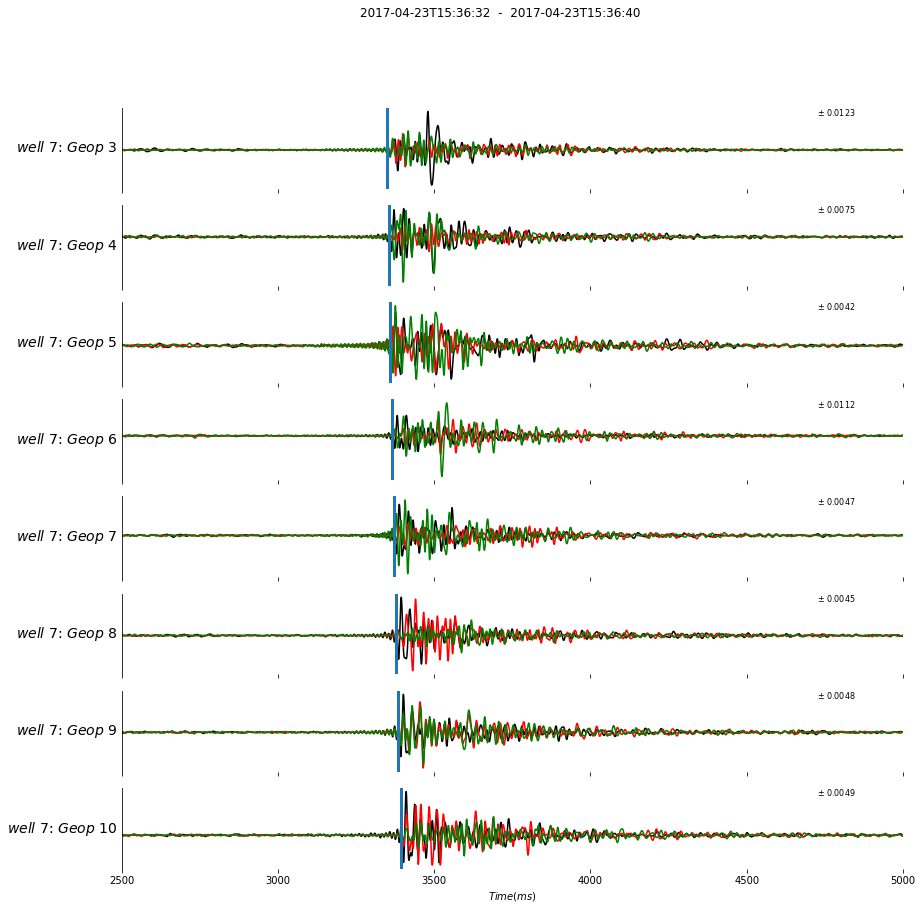

In [5]:
plot_vib_data(segy1, begin=2.5, end=5, col_width= 14)

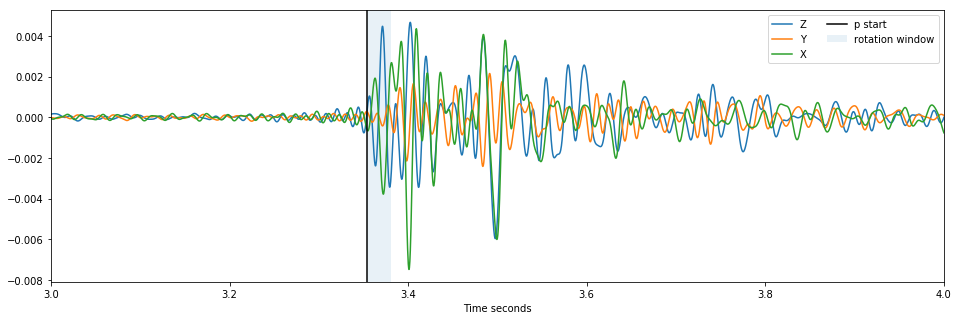

In [6]:
#choose an appropriate rotation window size
plot_geophone(segy1, geophone_no=2, zero_crossing=4, start=3.2, end=4)

In [7]:
def find_component_orientation(stream, zero_crossing = 4):
    
    df = pd.DataFrame(columns=['Geophone','X_orientation','Y_orientation',
                              'azimuth2source', 'dip2source', 'rectilineaity', 'shot_azimuth',
                              'shot_dip'])
    
    segy1 = stream.copy()
    no_geopphones = len(segy1) //3  
    
    for tr in range(no_geopphones):
        
        channelz = tr * 3

        t = np.linspace(0, segy1[channelz].stats.endtime - segy1[channelz].stats.starttime,
                                segy1[channelz].stats.npts, endpoint=True )




        p_pick_start = segy1[channelz].stats.segy.trace_header.\
        x_coordinate_of_ensemble_position_of_this_trace/1000000 

        pw_z = segy1[channelz].data[np.argmin(np.abs(t - p_pick_start))::].copy()
        pw_y = segy1[channelz+1].data[np.argmin(np.abs(t - p_pick_start))::].copy()
        pw_x = segy1[channelz+2].data[np.argmin(np.abs(t - p_pick_start))::].copy()


        zero_crossings_z = np.argwhere(np.diff(np.sign(pw_z)))[zero_crossing] 
        zero_crossings_y = np.argwhere(np.diff(np.sign(pw_y)))[zero_crossing] 
        zero_crossings_x = np.argwhere(np.diff(np.sign(pw_x)))[zero_crossing] 

        idx_zero_crossing = np.min([zero_crossings_z, zero_crossings_y, zero_crossings_x])



        pw_z = pw_z[0:int(idx_zero_crossing)]
        pw_y = pw_y[0:int(idx_zero_crossing)]
        pw_x = pw_x[0:int(idx_zero_crossing)]

        v = obspy.Trace(pw_z)
        v.stats = segy1[channelz].stats
        y = obspy.Trace(pw_y)
        y.stats = segy1[channelz+1].stats
        x = obspy.Trace(pw_x)
        x.stats = segy1[channelz+2].stats

    
        vib_coord_x = v.stats.segy.trace_header.source_coordinate_x/100
        vib_coord_y = v.stats.segy.trace_header.source_coordinate_y/100
        vib_coord_z = v.stats.segy.trace_header.receiver_group_elevation/100

        geophone_coord_x = v.stats.segy.trace_header.group_coordinate_x/100
        geophone_coord_y = v.stats.segy.trace_header.group_coordinate_y/100
        geophone_coord_z = v.stats.segy.trace_header.datum_elevation_at_receiver_group/100

        vect_a = np.array([vib_coord_x, vib_coord_y, vib_coord_z])
        vect_b = np.array([geophone_coord_x, geophone_coord_y, geophone_coord_z])

        vib_distance = np.linalg.norm(vect_b - vect_a)
        vib_plunge = np.rad2deg(np.arcsin((geophone_coord_z-vib_coord_z)/vib_distance))
        vib_azimuth =np.rad2deg(np.arctan2((vib_coord_x- geophone_coord_x),
                                  (vib_coord_y- geophone_coord_y)))
        vib_azimuth = (360 + vib_azimuth if vib_azimuth < 0 else vib_azimuth)

        v1 = v.data.copy()
        y1 = y.data.copy()
        x1 = x.data.copy()

        flin = particle_motion.partc_mot(v1,y1,x1)

        azm = np.asarray([i[0] for i in flin])

        y_azm_range = np.arange(0,360, 0.25)

        idx = np.abs(azm - vib_azimuth).argmin()

        y_com_azm = y_azm_range[idx]

        x_com_azm = (y_com_azm+90 if 0<= y_com_azm <270 else y_com_azm-270)
        
        z,n,e = rotate.rotate2zne(v1, 0, 90, y1, y_com_azm, 0, x1, x_com_azm, 0)
        azimuth, dip, rect, _ = fln(z,n,e)

        df.loc[tr] = [int(tr+1), x_com_azm,  y_com_azm, azimuth, -1 * dip, rect*100,
                      vib_azimuth, vib_plunge]
        
        
    
    return df
    
    

In [8]:
vib8_msw7 = find_component_orientation(segy1, zero_crossing=3)

In [9]:
vib8_msw7

,Geophone,X_orientation,Y_orientation,azimuth2source,dip2source,rectilineaity,shot_azimuth,shot_dip
0,1.0,264.25,174.25,83.403422,-22.546593,70.420738,83.457962,-46.810039
1,2.0,87.25,357.25,83.431802,-49.002048,88.802823,83.457962,-49.700921
2,3.0,227.75,137.75,83.468251,-34.088996,86.678522,83.457962,-52.284596
3,4.0,92.75,2.75,83.346893,-64.893505,72.582986,83.457962,-54.598570
4,5.0,67.75,337.75,83.468988,-44.554229,70.399283,83.457962,-56.676497
5,6.0,102.00,12.00,83.399348,-85.054618,75.427004,83.457962,-58.548033
6,7.0,298.50,208.50,83.385366,-58.642055,89.810393,83.457962,-60.239016
7,8.0,334.50,244.50,83.560903,-63.226220,81.567817,83.457962,-61.771812


dip is measured negative up from horizontal, postive down from horizontal.
since viroseis is located on ground surface and geophone downhole, dip should be negative value

In [10]:
#load orientation determined by a contractor

contractor = pd.read_excel('contract_vib8_msw7.xlsx')

In [11]:
contractor

,Geophone,x_orient,y_orient
0,1,288,198
1,2,81,351
2,3,228,138
3,4,94,4
4,5,66,336
5,6,167,77
6,7,303,213
7,8,332,242


AttributeError: 'DataFrame' object has no attribute 'Y_component_orientation'

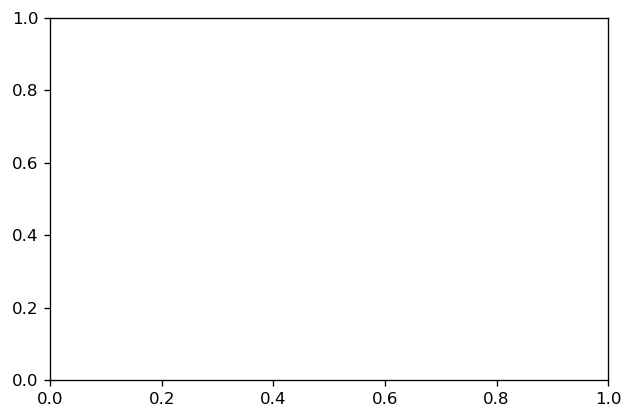

In [12]:
fig, ax = plt.subplots(dpi=120)

ax.plot(vib8_msw7.Geophone, vib8_msw7.Y_component_orientation, 'or', label = 'Y orient at MSW-7 vib8')
ax.plot(vib8_msw7.Geophone, vib8_msw7.Y_component_orientation, label='' )

ax.plot(contractor.Geophone, contractor.y_orient, 'ob', label = 'Y orient contract')
ax.plot(contractor.Geophone, contractor.y_orient, label='' )

ax.set_xlabel('Geophone Number')
ax.set_ylabel('Orientation from north')
ax.legend(loc = 'upper right', fontsize =8 )

C:\Anaconda3\lib\site-packages\matplotlib\projections\polar.py:153: RuntimeWarning: invalid value encountered in less
  theta = np.where(y < 0, 2 * np.pi - theta, theta)
C:\Anaconda3\lib\site-packages\matplotlib\projections\polar.py:157: RuntimeWarning: invalid value encountered in remainder
  theta %= 2 * np.pi


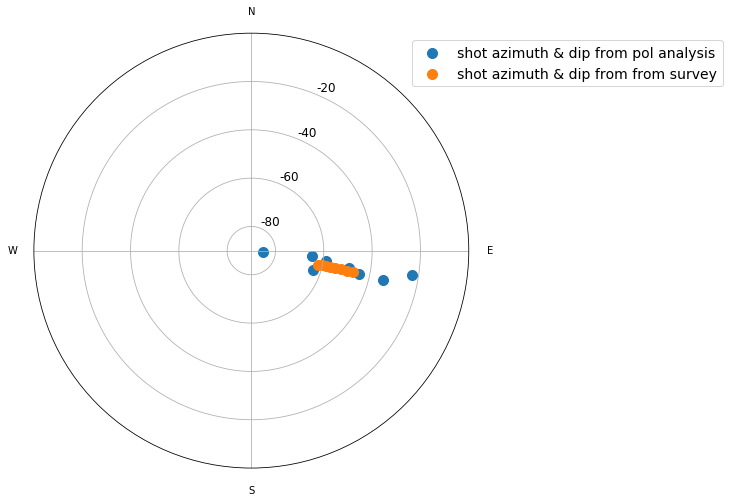

In [13]:
fig = plt.figure(figsize=(16,8))


ax = fig.add_subplot(111, projection='polar')




c = plt.scatter(vib8_msw7.azimuth2source,vib8_msw7.dip2source, s = 100,
                label = 'shot azimuth & dip from pol analysis')

d = plt.scatter(vib8_msw7.shot_azimuth,vib8_msw7.shot_dip, s = 100,
                label = 'shot azimuth & dip from from survey')

ax.set_theta_zero_location('N')
ax.set_theta_direction(-1)
ax.set_thetagrids([0,90, 180, 270], labels=['N', 'E', 'S', 'W'])
ax.set_rmax(-90)
ax.set_rticks([-20,-40,-60,-80])
ax.grid(which='minor')

ax.set_yticklabels([-20,-40,-60,-80], size = 12)
ax.legend(loc= 'upper right', fontsize = 14, bbox_to_anchor = [1.6, 1])